In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
tf.__version__

'2.2.0'

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 763786641302176974,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11357458798636474254
 physical_device_desc: "device: XLA_CPU device"]

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [13]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')
args['exp_id'] = '81.1-resnet_d3_dr_0.1.yml'

In [ ]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [7]:
ds_train = ds.sel(time=slice('2015', '2015'))

In [8]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], args['lead_time'], batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=1, norm_subsample=10, nt_in=args['nt_in'], dt_in=args['dt_in'], load=False
)

## Reference tests

In [7]:
%%time
# Default engine
X, y = dg_train[np.random.randint(len(dg_train))]

CPU times: user 7.73 s, sys: 19.4 s, total: 27.1 s
Wall time: 12.1 s


In [8]:
dg_train.shuffle = False; dg_train.on_epoch_end()  # Maybe doesn't matter because I am just reading in one year

In [9]:
%%time
X, y = dg_train[np.random.randint(len(dg_train))]

CPU times: user 7.62 s, sys: 17.1 s, total: 24.8 s
Wall time: 10 s


In [10]:
%%time
_ = dg_train.data.isel(time=777, level=0).load();

CPU times: user 404 ms, sys: 1.19 s, total: 1.59 s
Wall time: 1.59 s


In [24]:
%%time
_ = ds_train.isel(time=777, level=0).load();

CPU times: user 16.6 ms, sys: 1.21 ms, total: 17.8 ms
Wall time: 14.7 ms


Ok, this doesn't make any sense because it's accessing the same data. Is it because I've concatenated the levels?

In [26]:
var_dict = args['var_dict']
data = []
level_names = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
for long_var, params in var_dict.items():
    if long_var == 'constants':
        for var in params:
            data.append(ds_train[var].expand_dims(
                {'level': generic_level, 'time': ds_train.time}, (1, 0)
            ))
            level_names.append(var)
    else:
        var, levels = params
        try:
            data.append(ds_train[var].sel(level=levels))
            level_names += [f'{var}_{level}' for level in levels]
        except ValueError:
            data.append(ds_train[var].expand_dims({'level': generic_level}, 1))
            level_names.append(var)

data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
data['level_names'] = xr.DataArray(
    level_names, dims=['level'], coords={'level': data.level})

In [27]:
%%time
_ = data.isel(time=777, level=0).load();

CPU times: user 163 ms, sys: 643 ms, total: 806 ms
Wall time: 804 ms


Ok, weird. Somewhere inbetween but unacceptably slow. What about the normalization?

In [28]:
data = data.isel(time=slice(0, None, args['data_subsample']))

In [29]:
%%time
_ = data.isel(time=777, level=0).load();

CPU times: user 175 ms, sys: 551 ms, total: 726 ms
Wall time: 723 ms


In [30]:
data = (data - dg_train.mean) / dg_train.std

In [31]:
%%time
_ = data.isel(time=777, level=0).load();

CPU times: user 262 ms, sys: 832 ms, total: 1.09 s
Wall time: 1.09 s


Ok, so the concatenation makes it unbearably slow. Before we try to fix it, let's investigate accessing random time indices.

In [34]:
rand = np.random.randint(len(ds_train.time), size=10); rand

array([7871, 6466, 4342, 1703, 8173, 4710, 1983, 8113, 1876, 6970])

In [35]:
%%time
_ = dg_train.data.isel(time=rand, level=0).load();

CPU times: user 424 ms, sys: 925 ms, total: 1.35 s
Wall time: 1.34 s


In [36]:
%%time
_ = ds_train.isel(time=rand, level=0).load();

CPU times: user 21.1 ms, sys: 1.54 s, total: 1.56 s
Wall time: 1.55 s


In [37]:
%%time
_ = ds_train.isel(time=list(rand), level=0).load();

CPU times: user 13.2 ms, sys: 1.56 s, total: 1.57 s
Wall time: 1.56 s


In [38]:
%%time
_ = ds.isel(time=np.random.randint(len(ds.time), size=10), level=0).load();

CPU times: user 302 ms, sys: 15 s, total: 15.3 s
Wall time: 49.1 s


Ok, so this still takes forever. Especially across multiple files. So fixing the concatenation is kind of pointless. TFRecords it is...

In [39]:
%%time
# 461G-->463G
dg_train.data.load()

CPU times: user 5.8 s, sys: 6.2 s, total: 12 s
Wall time: 7.11 s


<xarray.DataArray 'z' (time: 8760, lat: 32, lon: 64, level: 38)>
array([[[[ 0.31925519, -1.07835869, -1.1621174 , ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.3187487 , -1.07663579, -1.15079192, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.31773573, -1.07491425, -1.13946645, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.32077947, -1.08008022, -1.19137591, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.32027298, -1.08008022, -1.18382522, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.31976408, -1.07950592, -1.17344288, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.31976408, -1.03817677, -1.11587124, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.31519848, -1.03243649, -1.09322028, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.31063047, -1.02612192, -1.0705682 , ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.33752483, -1.04506564, -1.15267932, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.33092846, -1.04678718, -1.14607288, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.3238232 , -1.04391704, -1.13380315, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.25633285, -1.13346423, -1.228184  , ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.24314012, -1.13748297, -1.19609496, ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.23096277, -1.13576143, -1.16117427, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.30656894, -1.09443091, -1.2036434 , ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.28830171, -1.11280033, -1.23573469, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.27054096, -1.12600242, -1.24611591, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-0.85497753, -1.00545666, -1.15079192, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-0.88593342, -0.9870886 , -1.12908411, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-0.93870676, -0.98364416, -1.12247767, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-0.85548643, -1.09213644, -1.20742043, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-0.84229128, -1.06056493, -1.20553304, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-0.84026293, -1.03128789, -1.18382634, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-1.291382  , -1.2408079 , -1.27065538, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-1.31726098, -1.22186418, -1.25838564, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-1.346695  , -1.20636626, -1.24234112, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-1.26499654, -1.29648774, -1.28009346, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-1.26397874, -1.28098982, -1.28292511, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-1.27362126, -1.2620461 , -1.2791492 , ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-1.56844866, -1.30050648, -1.21969017, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-1.57251019, -1.29821065, -1.21685852, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-1.57758469, -1.29648774, -1.21308261, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-1.56286768, -1.31198703, -1.21969017, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-1.56388065, -1.30796829, -1.2206333 , ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-1.56591141, -1.30395092, -1.22157756, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.31671794, -1.07548855, -1.15645522, ...,  1.44426201,
           2

In [40]:
%%time
X, y = dg_train[np.random.randint(len(dg_train))]

CPU times: user 39.1 ms, sys: 18.5 ms, total: 57.6 ms
Wall time: 56.4 ms


## TFRecords

In [259]:
var_dict = args['var_dict']
data = []
level_names = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
for long_var, params in var_dict.items():
    if long_var == 'constants':
        for var in params:
            data.append(ds_train[var].expand_dims(
                {'level': generic_level, 'time': ds_train.time}, (1, 0)
            ))
            level_names.append(var)
    else:
        var, levels = params
        try:
            data.append(ds_train[var].sel(level=levels))
            level_names += [f'{var}_{level}' for level in levels]
        except ValueError:
            data.append(ds_train[var].expand_dims({'level': generic_level}, 1))
            level_names.append(var)

data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
data['level_names'] = xr.DataArray(
    level_names, dims=['level'], coords={'level': data.level})

In [260]:
ds = data

In [264]:
def _tensor_feature(value):
    """Returns a float_list from a float / double."""
    value = tf.io.serialize_tensor(value).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [265]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [266]:
def serialize_example(time, data):
    feature = {
        'time': _bytes_feature(time),
        'data': _tensor_feature(data)
    }
    feature = tf.train.Features(feature=feature)
    example_proto = tf.train.Example(features=feature)
    return example_proto.SerializeToString()

In [257]:
type(time.encode('utf-8'))

bytes

In [267]:
filename = 'test4.tfrecord'
writer = tf.io.TFRecordWriter(filename)
for i in range(10):
    time = str(ds.isel(time=i).time.values).encode('utf-8')
    data = ds.isel(time=i).values.astype('float32')
    serialized_example = serialize_example(time, data)
    writer.write(serialized_example)

In [268]:
raw_ds = tf.data.TFRecordDataset([filename])

In [269]:
features = {
    'time': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.FixedLenFeature([], tf.string)
}

In [270]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, features)

In [ ]:
def decode(example_proto):
    dic = _parse(example_proto)
    # Get the data and normalize!

In [271]:
parsed_ds = raw_ds.map(_parse)

In [272]:
parsed_ds

<MapDataset shapes: {data: (), time: ()}, types: {data: tf.string, time: tf.string}>

In [290]:
parsed_ds = parsed_ds.shuffle(5)

In [291]:
for p in parsed_ds.take(9):
    print(p['time'])

tf.Tensor(b'2015-01-01T00:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T05:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T04:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T06:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T01:00:00.000000000', shape=(), dtype=string)


DataLossError: truncated record at 2802609

In [282]:
o = next(iter(parsed_ds))

In [283]:
o['time']

<tf.Tensor: shape=(), dtype=string, numpy=b'2015-01-01T00:00:00.000000000'>

## Shuffle across files

In [8]:
def _tensor_feature(value):
    """Returns a float_list from a float / double."""
    value = tf.io.serialize_tensor(value).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [9]:
def serialize_example(data):
    feature = {
        'data': _tensor_feature(data)
    }
    feature = tf.train.Features(feature=feature)
    example_proto = tf.train.Example(features=feature)
    return example_proto.SerializeToString()

In [10]:
n = 10

In [11]:
data = np.arange(n*10).reshape(n, -1).astype('float32')

In [12]:
for i in range(n):
    filename = f'ttest_data{i}.tfrecord'
    writer = tf.io.TFRecordWriter(filename)
    for j in range(10):
        serialized_example = serialize_example(data[i, j])
        writer.write(serialized_example)
    writer.close()

In [13]:
filenames = sorted(glob('ttest*'))

In [62]:
filenames

['ttest_data0.tfrecord',
 'ttest_data1.tfrecord',
 'ttest_data2.tfrecord',
 'ttest_data3.tfrecord',
 'ttest_data4.tfrecord',
 'ttest_data5.tfrecord',
 'ttest_data6.tfrecord',
 'ttest_data7.tfrecord',
 'ttest_data8.tfrecord',
 'ttest_data9.tfrecord']

### Current implementation

In [14]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, {'data': tf.io.FixedLenFeature([], tf.string)})

In [15]:
def decode(example_proto):
    dic = _parse(example_proto)
    data = dic['data']
    return tf.io.parse_tensor(data, np.float32)

In [16]:
dataset = tf.data.TFRecordDataset(filenames).map(decode)

In [17]:
batches = dataset.shuffle(20).batch(10).as_numpy_iterator()

In [18]:
bb = [b for b in batches]

In [19]:
bb

[array([ 7.,  1., 18., 14., 21., 10., 13.,  6.,  2., 15.], dtype=float32),
 array([12., 25., 27., 20., 33., 28., 19., 16., 22.,  3.], dtype=float32),
 array([23., 24., 32., 29.,  5., 39., 11., 37., 43., 44.], dtype=float32),
 array([40., 34., 46., 52., 41., 26., 55.,  9., 30.,  4.], dtype=float32),
 array([50., 45., 36., 61., 51., 62., 35., 65., 60., 59.], dtype=float32),
 array([68., 48., 56.,  8., 58., 53., 74., 49., 66., 78.], dtype=float32),
 array([17., 64., 67., 72., 80., 42., 57., 85., 63., 83.], dtype=float32),
 array([88., 89., 91., 81.,  0., 87., 71., 96., 38., 93.], dtype=float32),
 array([99., 47., 82., 94., 84., 86., 79., 73., 95., 70.], dtype=float32),
 array([90., 77., 69., 97., 54., 98., 92., 75., 31., 76.], dtype=float32)]

## Try with interleave

In [20]:
datasets = [tf.data.TFRecordDataset(fn).map(decode).shuffle(20).batch(2) for fn in filenames]

In [21]:
dataset = tf.data.Dataset.zip(tuple(datasets))

In [22]:
batches = dataset.as_numpy_iterator()

In [23]:
b = list(batches)[0]

In [25]:
np.array(b)

array([[ 4.,  7.],
       [16., 10.],
       [27., 22.],
       [37., 33.],
       [43., 44.],
       [57., 50.],
       [69., 61.],
       [71., 77.],
       [80., 88.],
       [97., 99.]], dtype=float32)

In [87]:
# batches = dataset.shuffle(20).batch(10).as_numpy_iterator()

In [79]:
bb

[array([ 0., 11., 21., 30., 24.,  2., 13.,  1., 10., 25.], dtype=float32),
 array([ 6., 17., 22.,  4., 20., 16., 32., 18.,  9., 29.], dtype=float32),
 array([ 8.,  5., 19., 50., 26.,  3., 27., 12., 70., 31.], dtype=float32),
 array([38., 42., 52., 40., 37.,  7., 53., 61., 71., 44.], dtype=float32),
 array([60., 23., 34., 39., 74., 28., 54., 55., 56., 73.], dtype=float32),
 array([51., 76., 43., 47., 58., 67., 45., 68., 15., 48.], dtype=float32),
 array([35., 57., 36., 49., 81., 41., 91., 66., 62., 46.], dtype=float32),
 array([75., 65., 59., 64., 84., 82., 72., 69., 14., 97.], dtype=float32),
 array([79., 94., 95., 63., 80., 88., 99., 87., 78., 92.], dtype=float32),
 array([93., 96., 77., 33., 90., 86., 85., 98., 83., 89.], dtype=float32)]

In [110]:
dataset = tf.data.Dataset.from_tensor_slices(filenames)

In [34]:
dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [268]:
raw_ds = tf.data.TFRecordDataset([filename])

In [269]:
features = {
    'time': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.FixedLenFeature([], tf.string)
}

In [270]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, features)

In [ ]:
def decode(example_proto):
    dic = _parse(example_proto)
    # Get the data and normalize!

In [271]:
parsed_ds = raw_ds.map(_parse)

In [272]:
parsed_ds

<MapDataset shapes: {data: (), time: ()}, types: {data: tf.string, time: tf.string}>

In [290]:
parsed_ds = parsed_ds.shuffle(5)

In [291]:
for p in parsed_ds.take(9):
    print(p['time'])

tf.Tensor(b'2015-01-01T00:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T05:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T04:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T06:00:00.000000000', shape=(), dtype=string)
tf.Tensor(b'2015-01-01T01:00:00.000000000', shape=(), dtype=string)


DataLossError: truncated record at 2802609

In [282]:
o = next(iter(parsed_ds))

In [283]:
o['time']

<tf.Tensor: shape=(), dtype=string, numpy=b'2015-01-01T00:00:00.000000000'>

## Implement from data generator

In [8]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], args['lead_time'], batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=1, norm_subsample=10, nt_in=1, dt_in=args['dt_in'], load=True, normalize=False, 
    shuffle=False
)

In [9]:
def _tensor_feature(value):
    value = tf.io.serialize_tensor(value).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [10]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [11]:
def serialize_example(time, data):
    feature = {
        'time': _bytes_feature(time),
        'data': _tensor_feature(data)
    }
    feature = tf.train.Features(feature=feature)
    example_proto = tf.train.Example(features=feature)
    return example_proto.SerializeToString()

In [12]:
savedir = '/data/stephan/WeatherBench/tfrecords/'
!mkdir -p $savedir

In [13]:
filename = f'{savedir}test1.tfrecord'

In [322]:
!rm $filename

In [323]:
writer = tf.io.TFRecordWriter(filename)

In [324]:
for t in tqdm(dg_train.data.time):
    time = str(t.values).encode('utf-8')
    data = dg_train.data.sel(time=t).values.astype('float32')
    serialized_example = serialize_example(time, data)
    writer.write(serialized_example)

In [325]:
writer.close()

In [14]:
!ls -lh $savedir

total 3,0G
-rw-rw-r-- 1 rasp rasp 221M Jun  7 15:07 month_01.tfrecord
-rw-rw-r-- 1 rasp rasp 200M Jun  7 16:06 month_02.tfrecord
-rw-rw-r-- 1 rasp rasp 2,6G Jun  7 15:01 test1.tfrecord


Too large. 1 year = 2.6G. Should be around 100-200G. What about one month? 2.6/12 = 216M. Let's try reading it to check whether the different lengths would be a problem.

In [56]:
np.unique(ds.time.dt.year)

[autoreload of src.data_generator failed: Traceback (most recent call last):
  File "/home/rasp/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/rasp/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/rasp/miniconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/rasp/miniconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/rasp/repositor

'[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992\n 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006\n 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]'

In [330]:
for m in tqdm(range(1, 3)):
    data_slice = dg_train.data.sel(time=f'2015-{str(m).zfill(2)}')
    filename = f'{savedir}month_{str(m).zfill(2)}.tfrecord'
    writer = tf.io.TFRecordWriter(filename)
    for t in tqdm(data_slice.time):
        time = str(t.values).encode('utf-8')
        data = data_slice.sel(time=t).values.astype('float32')
        serialized_example = serialize_example(time, data)
        writer.write(serialized_example)

In [331]:
write.close()

In [332]:
!ls -lh $savedir

total 3,0G
-rw-rw-r-- 1 rasp rasp 221M Jun  7 15:07 month_01.tfrecord
-rw-rw-r-- 1 rasp rasp 200M Jun  7 15:07 month_02.tfrecord
-rw-rw-r-- 1 rasp rasp 2,6G Jun  7 15:01 test1.tfrecord


### Now read the data

In [22]:
features = {
    'time': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.FixedLenFeature([], tf.string)
}

In [15]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, features)
def decode(example_proto):
    dic = _parse(example_proto)
    time = dic['time']
    data = dic['data']
    # Normalize I guess
    return tf.io.parse_tensor(data, np.float32)
def decode_time(example_proto):
    dic = _parse(example_proto)
    time = dic['time']
    data = dic['data']
    # Normalize I guess
    return time

In [16]:
lead_time=72

In [17]:
filenames = [f'{savedir}month_{str(m).zfill(2)}.tfrecord' for m in range(1, 3)]

In [78]:
raw_ds = tf.data.TFRecordDataset(filenames)

In [79]:
parsed_ds = raw_ds.map(decode_time)

In [80]:
pp = [p for p in parsed_ds]

In [81]:
len(pp)

1416

In [82]:
parsed_ds._

TypeError: 'MapDataset' object is not subscriptable

In [35]:
batch = parsed_ds

In [36]:
batch2 = parsed_ds.skip(lead_time)

In [26]:
bb = [b for b in batch]

In [27]:
len(bb)

44

In [37]:
combined = tf.data.Dataset.zip((batch, batch2))

In [47]:
cc = combined.batch(32)

In [85]:
ccc = cc.__iter__()

In [86]:
next(ccc)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'2015-01-01T00:00:00.000000000', b'2015-01-01T01:00:00.000000000',
        b'2015-01-01T02:00:00.000000000', b'2015-01-01T03:00:00.000000000',
        b'2015-01-01T04:00:00.000000000', b'2015-01-01T05:00:00.000000000',
        b'2015-01-01T06:00:00.000000000', b'2015-01-01T07:00:00.000000000',
        b'2015-01-01T08:00:00.000000000', b'2015-01-01T09:00:00.000000000',
        b'2015-01-01T10:00:00.000000000', b'2015-01-01T11:00:00.000000000',
        b'2015-01-01T12:00:00.000000000', b'2015-01-01T13:00:00.000000000',
        b'2015-01-01T14:00:00.000000000', b'2015-01-01T15:00:00.000000000',
        b'2015-01-01T16:00:00.000000000', b'2015-01-01T17:00:00.000000000',
        b'2015-01-01T18:00:00.000000000', b'2015-01-01T19:00:00.000000000',
        b'2015-01-01T20:00:00.000000000', b'2015-01-01T21:00:00.000000000',
        b'2015-01-01T22:00:00.000000000', b'2015-01-01T23:00:00.000000000',
        b'2015-01-02T00:00:00.000000000',

In [48]:
bb = [b for b in cc]

In [49]:
len(bb)

42

In [50]:
bb[0], bb[-1]

((<tf.Tensor: shape=(32,), dtype=string, numpy=
  array([b'2015-01-01T00:00:00.000000000', b'2015-01-01T01:00:00.000000000',
         b'2015-01-01T02:00:00.000000000', b'2015-01-01T03:00:00.000000000',
         b'2015-01-01T04:00:00.000000000', b'2015-01-01T05:00:00.000000000',
         b'2015-01-01T06:00:00.000000000', b'2015-01-01T07:00:00.000000000',
         b'2015-01-01T08:00:00.000000000', b'2015-01-01T09:00:00.000000000',
         b'2015-01-01T10:00:00.000000000', b'2015-01-01T11:00:00.000000000',
         b'2015-01-01T12:00:00.000000000', b'2015-01-01T13:00:00.000000000',
         b'2015-01-01T14:00:00.000000000', b'2015-01-01T15:00:00.000000000',
         b'2015-01-01T16:00:00.000000000', b'2015-01-01T17:00:00.000000000',
         b'2015-01-01T18:00:00.000000000', b'2015-01-01T19:00:00.000000000',
         b'2015-01-01T20:00:00.000000000', b'2015-01-01T21:00:00.000000000',
         b'2015-01-01T22:00:00.000000000', b'2015-01-01T23:00:00.000000000',
         b'2015-01-02T00:00:

In [399]:
for b, c in cc.take():
    print(b, c)

tf.Tensor(
[[b'2015-01-02T14:00:00.000000000' b'2015-01-02T15:00:00.000000000']
 [b'2015-01-04T14:00:00.000000000' b'2015-01-04T15:00:00.000000000']
 [b'2015-01-03T14:00:00.000000000' b'2015-01-03T15:00:00.000000000']
 [b'2015-01-09T04:00:00.000000000' b'2015-01-09T05:00:00.000000000']
 [b'2015-01-07T20:00:00.000000000' b'2015-01-07T21:00:00.000000000']
 [b'2015-01-09T06:00:00.000000000' b'2015-01-09T07:00:00.000000000']
 [b'2015-01-05T08:00:00.000000000' b'2015-01-05T09:00:00.000000000']
 [b'2015-01-04T06:00:00.000000000' b'2015-01-04T07:00:00.000000000']
 [b'2015-01-07T16:00:00.000000000' b'2015-01-07T17:00:00.000000000']
 [b'2015-01-02T12:00:00.000000000' b'2015-01-02T13:00:00.000000000']
 [b'2015-01-03T02:00:00.000000000' b'2015-01-03T03:00:00.000000000']
 [b'2015-01-04T22:00:00.000000000' b'2015-01-04T23:00:00.000000000']
 [b'2015-01-02T08:00:00.000000000' b'2015-01-02T09:00:00.000000000']
 [b'2015-01-08T02:00:00.000000000' b'2015-01-08T03:00:00.000000000']
 [b'2015-01-07T00:00:00

DataLossError: truncated record at 208950071

In [382]:
for b in batch.take(1):
    pass

In [383]:
b

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'2015-01-01T00:00:00.000000000', b'2015-01-01T01:00:00.000000000'],
      dtype=object)>

In [384]:
X = next(iter(parsed_ds))

In [387]:
X.numpy()

b'2015-01-01T00:00:00.000000000'

## Now the full implementation

In [9]:
!rm /data/stephan/WeatherBench/tfrecords/ERA/*

In [14]:
ds_train = ds.sel(time=slice('2015', '2015'))

In [15]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], args['lead_time'], batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=1, norm_subsample=10, nt_in=1, dt_in=args['dt_in'], load=True, normalize=False, shuffle=False
)

In [16]:
savedir = '/data/stephan/WeatherBench/tfrecords/ERA/'
!mkdir -p $savedir

In [17]:
dg_train.to_tfrecord(savedir)

In [18]:
dg_train.mean.to_netcdf(f'{savedir}mean.nc')
dg_train.std.to_netcdf(f'{savedir}std.nc')

In [221]:
fns = sorted(glob('/data/stephan/WeatherBench/TFR/era_5.625_1979_2015//*.tfrecord'))

In [23]:
features = {
    'time': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.FixedLenFeature([], tf.string)
}

In [24]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, features)

In [25]:
def decode(example_proto):
    dic = _parse(example_proto)
    time = dic['time']
    data = dic['data']
#     return tf.io.parse_tensor(data, np.float32)
    return time

In [26]:
len(fns)

12

In [27]:
nt_in = 3
dt_in = 2

In [28]:
lead_time=72

In [225]:
len(range(1979, 2016))

37

In [226]:
len(fns)

444

In [240]:
444%17

2

In [241]:
files_per_dataset = 17

In [242]:
fnss = [fns[i*files_per_dataset:i*files_per_dataset+files_per_dataset] for i in range(len(fns)//files_per_dataset)]

In [243]:
[f[0] for f in fnss]

['/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1979-01.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1980-06.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1981-11.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1983-04.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1984-09.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1986-02.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1987-07.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1988-12.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1990-05.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1991-10.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1993-03.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1994-08.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1996-01.tfrecord',
 '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/1997-06.tfr

In [39]:
nt_in = 1
dt_in = 2
nt_offset = (nt_in - 1) * dt_in

In [40]:
lead_time=72
cont_time=True

In [119]:
tf.random.uniform([10], 1, 3, dtype=tf.int32)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 2, 1, 1, 2, 2, 2, 2, 1], dtype=int32)>

In [94]:
def fnc(fn):
    window_size = lead_time + nt_offset + 1
    d = tf.data.TFRecordDataset(fn)
    d = d.map(decode).window(window_size, shift=1, drop_remainder=True).flat_map(
        lambda window: window.batch(window_size))
#     if cont_time:
# #         y_slice = slice(nt_offset+1, None)
#         y_slice = 
#     else:
#         y_slice = -1
    if nt_in > 1:
        d = d.map(lambda window: ([window[n*dt_in] for n in range(nt_in)], window[y_slice]))
    else:
        if cont_time:
            def slice_func(window):
#                 nt = np.random.randint(nt_offset+1, window_size)
                nt = tf.random.uniform([1], nt_offset+1, window_size, dtype=tf.int32)[0]
                return window[0], window[nt], nt
            d = d.map(slice_func)
        else:
            d = d.map(lambda window: (window[0], window[y_slice]))
    return d

In [95]:
dataset = tf.data.Dataset.from_tensor_slices(fnss)

In [96]:
dataset = dataset.interleave(fnc, cycle_length=4, block_length=1, num_parallel_calls=1)

In [97]:
dataset = dataset.repeat().batch(2)
# dataset = dataset.shuffle(1000).repeat().batch(10)

In [98]:
for e in dataset.take(2):
    print(e)
    print('\n')

(<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'2015-01-01T00:00:00.000000000', b'2015-06-01T00:00:00.000000000'],
      dtype=object)>, <tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'2015-01-03T23:00:00.000000000', b'2015-06-02T17:00:00.000000000'],
      dtype=object)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([71, 41], dtype=int32)>)


(<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'2015-01-01T01:00:00.000000000', b'2015-06-01T01:00:00.000000000'],
      dtype=object)>, <tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'2015-01-03T07:00:00.000000000', b'2015-06-03T19:00:00.000000000'],
      dtype=object)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([54, 66], dtype=int32)>)




In [99]:
dataset = dataset.as_numpy_iterator()

In [100]:
X, y, nt = next(dataset)

In [101]:
nt

array([ 5, 56], dtype=int32)

In [627]:
nt = np.random.randint(1, lead_time + 1, 2)

In [628]:
y.shape

(2, 72)

In [629]:
nt

array([23, 24])

In [630]:
y[np.arange(len(y)), nt]

array([b'2015-01-02T04:00:00.000000000', b'2015-06-02T05:00:00.000000000'],
      dtype=object)

In [623]:
y[]

IndexError: index 65 is out of bounds for axis 0 with size 2

In [620]:
X

array([[b'2015-01-01T00:00:00.000000000',
        b'2015-01-01T02:00:00.000000000',
        b'2015-01-01T04:00:00.000000000'],
       [b'2015-06-01T00:00:00.000000000',
        b'2015-06-01T02:00:00.000000000',
        b'2015-06-01T04:00:00.000000000']], dtype=object)

In [619]:
y[:, nt]

array([[b'2015-01-03T22:00:00.000000000',
        b'2015-01-02T14:00:00.000000000'],
       [b'2015-06-03T22:00:00.000000000',
        b'2015-06-02T14:00:00.000000000']], dtype=object)

In [263]:
ds_train = ds.sel(time=slice('2015', '2015'))

In [291]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], args['lead_time'], batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=1, norm_subsample=10, nt_in=3, dt_in=2, load=True, normalize=True, shuffle=False,
    mean=xr.open_dataarray(f'{savedir}mean.nc'), std=xr.open_dataarray(f'{savedir}std.nc'), cont_time=True,
    fixed_time=True
)

In [292]:
Xref, yref = dg_train[0]

In [293]:
Xref.shape, yref.shape

((32, 32, 64, 115), (32, 32, 64, 2))

In [294]:
Xref[:5, 0, 0, np.array([0, 38])]

array([[0.31925517, 0.32128596],
       [0.31671792, 0.31671792],
       [0.32128596, 0.32027298],
       [0.31671792, 0.31925517],
       [0.32027298, 0.32585397]], dtype=float32)

In [295]:
yref[:5, 0, 0, 0]

array([-1.0214903, -1.0205473, -1.0167713, -1.0120523, -1.0139408],
      dtype=float32)

### Script

In [129]:
True is not None

True

In [133]:
def convert_to_tfr(savedir, var_dict, datadir, years, cmip=False, cmip_dir=None, compute_norm=True, 
                   norm_subsample=30000, data_subsample=1):
    # Open dataset and create data generators
    if cmip:
        # Load vars
        tmp_dict = var_dict.copy()
        constants = tmp_dict.pop('constants')
        ds = xr.merge(
            [xr.open_mfdataset(f'{cmip_dir}/{var}/*.nc', combine='by_coords')
             for var in tmp_dict.keys()] +
            [xr.open_mfdataset(f'{datadir}/constants/*.nc', combine='by_coords')],
            fill_value=0  # For the 'tisr' NaNs
        )
        # pdb.set_trace()
        ds = ds.assign_coords(plev= ds['plev'] / 100)
        ds = ds.rename({'plev': 'level'})
    else:
        ds = xr.merge(
            [xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords')
             for var in var_dict.keys()],
            fill_value=0  # For the 'tisr' NaNs
        )
    ds = ds.sel(time=slice(*years))
    dg = DataGenerator(
        ds, var_dict, lead_time=1, batch_size=1,
        data_subsample=data_subsample, norm_subsample=norm_subsample,
        mean=None if compute_norm else '', std=None if compute_norm else '',
        normalize=False, shuffle=False, load=True, verbose=True
    )
    dg.to_tfrecord(savedir)
    if compute_norm:
        dg.mean.to_netcdf(f'{savedir}mean.nc')
        dg.std.to_netcdf(f'{savedir}std.nc')
    

In [134]:
convert_to_tfr(
    savedir=savedir, 
    var_dict=args['var_dict'], 
    datadir=args['datadir'], 
    years=['2015', '2015'], 
    compute_norm=True,
)

DG start 13:19:22.243078
DG normalize 13:19:22.277990
DG load 13:19:27.126965
Loading data into RAM
DG done 13:19:33.796897


## Ok here comes the hard part

Reading in the data in exactly the same way

In [117]:
%load_ext line_profiler

In [194]:
ds_train = ds.sel(time=slice('1979', '2015'))

In [274]:
tfrecord_files = '/data/stephan/WeatherBench/tfrecords/ERA/2015*'
savedir = '/data/stephan/WeatherBench/tfrecords/ERA/'


In [195]:
tfrecord_files = '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/*.tfrecord'
savedir = '/data/stephan/WeatherBench/TFR/era_5.625_1979_2015/'

In [236]:
444%17

2

In [237]:
444/17

26.11764705882353

In [280]:
!ls $savedir/*.tfrecord | wc

     12      12     708


In [296]:
dg_tfr = DataGenerator(
    ds_train, args['var_dict'], args['lead_time'], batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=1, norm_subsample=10, nt_in=3, dt_in=2, load=False, normalize=True, shuffle=False,
    mean=xr.open_dataarray(f'{savedir}mean.nc'), std=xr.open_dataarray(f'{savedir}std.nc'),
    tfrecord_files=tfrecord_files, tfr_return_time=False, tfr_cycle_length=1, tfr_num_parallel_calls=1,
    tfr_buffer_size=1000, tfr_fpds=1, cont_time=True, fixed_time=True
)

In [297]:
%%time
Xtf, ytf = next(iter(dg_tfr))

CPU times: user 523 ms, sys: 994 ms, total: 1.52 s
Wall time: 728 ms


In [298]:
Xtf.shape, ytf.shape

((32, 32, 64, 115), (32, 32, 64, 2))

In [299]:
Xtf[:5, 0, 0, np.array([0, 38])]

array([[0.31925517, 0.32128596],
       [0.31671792, 0.31671792],
       [0.32128596, 0.32027298],
       [0.31671792, 0.31925517],
       [0.32027298, 0.32585397]], dtype=float32)

In [300]:
ytf[:5, 0, 0, 0]

array([-1.02149039, -1.02054725, -1.01677135, -1.0120523 , -1.01394082])

In [117]:
%%timeit 
next(iter(dg_tfr))

257 ms ± 5.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now try training a model

In [37]:
model_ref = build_resnet(
    [64, 64, 2], [7, 3, 3], input_shape=dg_tfr.shape,
    bn_position=args['bn_position'], use_bias=args['use_bias'], l2=args['l2'], skip=args['skip'],
    dropout=args['dropout'], activation=args['activation']
)

In [38]:
model_ref.compile('adam', 'mse')

In [39]:
model_ref.fit(dg_tfr)

  ...
    to  
  ['...']
Train for 4656 steps
4656/4656 [==============================] - 213s 46ms/step - loss: 0.2060


In [239]:

dataset = tf.data.Dataset.from_tensor_slices(np.arange(20))
dataset = dataset.shuffle(buffer_size=20)

In [240]:
dataset = dataset.batch(10)

In [241]:
bb = [b for b in dataset]

In [242]:
bb

[<tf.Tensor: shape=(10,), dtype=int64, numpy=array([17, 10,  6,  9,  7,  5, 18, 11,  0,  4])>,
 <tf.Tensor: shape=(10,), dtype=int64, numpy=array([12,  3, 15, 14, 16, 13, 19,  8,  2,  1])>]

## Valid/test generator and check whether I get the same results

In [149]:
args = load_args('../nn_configs/B/131-resnet_d3_3d_pre_cmip.yml')

In [150]:
valdir = args['datadir']

In [151]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid], compat='override')

In [152]:
args['tfrecord_files'] = '/data/stephan/WeatherBench/TFR/era_5.625_1979_2018/*.tfrecord'

In [156]:
args['test_years'] = ['2017', '2017']
args['data_subsample'] = 1

In [157]:
dg_test = load_data(**args, only_test=True)

In [139]:
model = keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/131-resnet_d3_3d_pre_cmip.h5', 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

In [144]:
dg_test.tfr_return_time = True
dg_test._setup_tfrecord_ds()

In [145]:
ys = []
for X, y in dg_test.tfr_dataset:
    ys.append(y)

In [146]:
ys = np.concatenate(ys)

In [147]:
len(ys)

8686

In [148]:
ys

array([b'2017-01-04T02:00:00.000000000', b'2017-01-04T03:00:00.000000000',
       b'2017-01-04T04:00:00.000000000', ...,
       b'2017-12-31T21:00:00.000000000', b'2017-12-31T22:00:00.000000000',
       b'2017-12-31T23:00:00.000000000'], dtype=object)

In [158]:
preds = create_predictions(model, dg_test, verbose=1)

272/272 [==============================] - 85s 311ms/step


UnknownError: 2 root error(s) found.
  (0) Unknown:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py", line 1897, in execution_mode
    yield

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 659, in _next_internal
    output_shapes=self._flat_output_shapes)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 2479, in iterator_get_next_sync
    _ops.raise_from_not_ok_status(e, name)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 6606, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)

  File "<string>", line 3, in raise_from

tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence [Op:IteratorGetNextSync]


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 674, in next
    return self._next_internal()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 665, in _next_internal
    return structure.from_compatible_tensor_list(self._element_spec, ret)

  File "/home/rasp/miniconda3/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(type, value, traceback)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py", line 1900, in execution_mode
    executor_new.wait()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/executor.py", line 67, in wait
    pywrap_tensorflow.TFE_ExecutorWaitForAllPendingNodes(self._handle)

tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "/home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py", line 202, in __getitem__
    return self._get_tfrecord_item(i)

  File "/home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py", line 307, in _get_tfrecord_item
    X, y = next(self.tfr_dataset)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 3642, in __next__
    return self.next()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 3639, in next
    return nest.map_structure(lambda x: x.numpy(), next(self._iterator))

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 630, in __next__
    return self.next()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 676, in next
    raise StopIteration

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 236, in __call__
    ret = func(*args)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  RuntimeError: generator raised StopIteration
Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py", line 1897, in execution_mode
    yield

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 659, in _next_internal
    output_shapes=self._flat_output_shapes)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 2479, in iterator_get_next_sync
    _ops.raise_from_not_ok_status(e, name)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 6606, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)

  File "<string>", line 3, in raise_from

tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence [Op:IteratorGetNextSync]


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 674, in next
    return self._next_internal()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 665, in _next_internal
    return structure.from_compatible_tensor_list(self._element_spec, ret)

  File "/home/rasp/miniconda3/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(type, value, traceback)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/context.py", line 1900, in execution_mode
    executor_new.wait()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/eager/executor.py", line 67, in wait
    pywrap_tensorflow.TFE_ExecutorWaitForAllPendingNodes(self._handle)

tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/data_adapter.py", line 975, in generator_fn
    yield x[i]

  File "/home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py", line 202, in __getitem__
    return self._get_tfrecord_item(i)

  File "/home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py", line 307, in _get_tfrecord_item
    X, y = next(self.tfr_dataset)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 3642, in __next__
    return self.next()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 3639, in next
    return nest.map_structure(lambda x: x.numpy(), next(self._iterator))

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 630, in __next__
    return self.next()

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 676, in next
    raise StopIteration

StopIteration


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 236, in __call__
    ret = func(*args)

  File "/home/rasp/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 789, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

RuntimeError: generator raised StopIteration


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_81514]

Function call stack:
distributed_function -> distributed_function


In [ ]:
compute_weighted_rmse(preds, valid_data).load()

In [105]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [106]:
ds_test = ds.sel(time=slice(*args['test_years']))

In [108]:
tfrecord_files = sorted(glob(args["tfrecord_files"] ))
test_files = [t for t in tfrecord_files if int(t.split('/')[-1].split('-')[0]) in
                      range(int(args["test_years"][0]), int(args["test_years"][1]) + 1)]

In [123]:
dg_tfr = DataGenerator(
    ds_test, args["var_dict"], 72, batch_size=128,
    data_subsample=1,
    mean=xr.open_dataarray(args['ext_mean']),
    std=xr.open_dataarray(args['ext_std']),
    shuffle=False, output_vars=args["output_vars"], nt_in=3, dt_in=1,
    tfrecord_files=test_files, tfr_cycle_length=1,
    tfr_num_parallel_calls=1,
    tfr_buffer_size=1, tfr_fpds=len(test_files or []),
    tfr_prefetch=None,
)

In [124]:
dg_ref = DataGenerator(
    ds_test, args["var_dict"], 72, batch_size=128,
    data_subsample=1,
    mean=xr.open_dataarray(args['ext_mean']),
    std=xr.open_dataarray(args['ext_std']),
    shuffle=False, output_vars=args["output_vars"], nt_in=3, dt_in=1,
)

In [132]:
X_ref, y_ref = dg_ref[1]

In [129]:
X_tfr, y_tfr = dg_tfr[0]

In [133]:
X_ref[0, 0, 0, 0], X_tfr[0, 0, 0, 0]

(0.5887432, 0.5887431901513775)

In [134]:
y_ref[0, 0, 0, 0], y_tfr[0, 0, 0, 0]

(-0.9864333, -0.9864333163412631)

In [62]:
dg_train, dg_valid, dg_test = load_data(**args)

In [80]:
args['tfrecord_files'] = None

In [86]:
dg_ref = load_data(**args, only_test=True)

In [87]:
X_ref, y_ref = dg_ref[0]

In [88]:
X, y = dg_test[0]

In [90]:
X_ref.shape, X.shape

((32, 32, 64, 114), (32, 32, 64, 114))

In [92]:
X_ref[0, 0, 0, 0], X[0, 0, 0, 0]

(0.5564306, 0.5813259005174037)

In [95]:
dg_ref.valid_time

<xarray.DataArray 'time' (time: 8686)>
array(['2017-01-04T02:00:00.000000000', '2017-01-04T03:00:00.000000000',
       '2017-01-04T04:00:00.000000000', ..., '2017-12-31T21:00:00.000000000',
       '2017-12-31T22:00:00.000000000', '2017-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2017-12-31T23:00:00
Attributes:
    long_name:  time

In [97]:
dg_test.valid_time

<xarray.DataArray 'time' (time: 8686)>
array(['2017-01-04T02:00:00.000000000', '2017-01-04T03:00:00.000000000',
       '2017-01-04T04:00:00.000000000', ..., '2017-12-31T21:00:00.000000000',
       '2017-12-31T22:00:00.000000000', '2017-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2017-12-31T23:00:00
Attributes:
    long_name:  time

In [79]:
# args = load_args('../nn_configs/B/131-resnet_d3_3d_pre_cmip.yml')

In [9]:
model = keras.models.load_model(
    '/home/rasp/data/myWeatherBench/predictions/saved_models/131-resnet_d3_3d_pre_cmip.h5', 
                                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})

In [12]:
model.evaluate(dg_valid, verbose=1)

  ...
    to  
  ['...']
137/137 [==============================] - 48s 351ms/step - loss: 0.0150


0.015036875246106272

In [63]:
preds = create_predictions(model, dg_test)

In [66]:
valdir = args['datadir']

In [70]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid], compat='override')

In [73]:
compute_weighted_rmse(preds, valid_data).load()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t        float64 3.249
    z        float64 668.0

## Debug

In [43]:
z500_valid = load_test_data(f'/data/stephan/WeatherBench/5.625deg/geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'/data/stephan/WeatherBench/5.625deg/temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [211]:
args = load_args('../nn_configs/B/136-resnet_tfr_ref.yml')

In [212]:
args['test_years'] = ['2017', '2017']

In [213]:
args125 = load_args('../nn_configs/B/125-resnet_d3_3d_cmip.yml')

In [214]:
args['ext_mean'] = xr.open_dataarray(f'{args125["model_save_dir"]}/{args125["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args125["model_save_dir"]}/{args125["exp_id"]}_std.nc')

In [215]:
dg_train_tfr, dg_valid_tfr, dg_test_tfr = load_data(**args)

In [164]:
args['tfrecord_files'] = None

In [165]:
dg_train_ref, dg_valid_ref, dg_test_ref = load_data(**args)

In [203]:
# dg_test_tfr.tfr_return_time = True
# dg_test_tfr.tfr_repeat = False
# dg_test_tfr._setup_tfrecord_ds()

In [204]:
# Xs, ys = [], []
# for _ in range(len(dg_test_tfr)):
#     X, y = next(dg_test_tfr.tfr_dataset)
#     Xs.append(X)
#     ys.append(y)

In [208]:
ys[-1]

array([b'2017-12-31T10:00:00.000000000', b'2017-12-31T11:00:00.000000000',
       b'2017-12-31T12:00:00.000000000', b'2017-12-31T13:00:00.000000000',
       b'2017-12-31T14:00:00.000000000', b'2017-12-31T15:00:00.000000000',
       b'2017-12-31T16:00:00.000000000', b'2017-12-31T17:00:00.000000000',
       b'2017-12-31T18:00:00.000000000', b'2017-12-31T19:00:00.000000000',
       b'2017-12-31T20:00:00.000000000', b'2017-12-31T21:00:00.000000000',
       b'2017-12-31T22:00:00.000000000', b'2017-12-31T23:00:00.000000000'],
      dtype=object)

In [207]:
dg_test_tfr.valid_time

<xarray.DataArray 'time' (time: 8686)>
array(['2017-01-04T02:00:00.000000000', '2017-01-04T03:00:00.000000000',
       '2017-01-04T04:00:00.000000000', ..., '2017-12-31T21:00:00.000000000',
       '2017-12-31T22:00:00.000000000', '2017-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2017-12-31T23:00:00
Attributes:
    long_name:  time

In [216]:
dg_test_tfr.tfr_repeat=False
dg_test_tfr._setup_tfrecord_ds()
X_tfr, y_tfr = dg_test_tfr[0]

In [217]:
X_tfr[0, 0, 0, 0], X_ref[0, 0, 0, 0], X_tfr[-1, 0, 0, 0], X_ref[-1, 0, 0, 0]

(0.5564305955142431, 0.5564306, 0.5823847912692385, 0.58238477)

In [218]:
y_tfr[0, 0, 0, 0], y_ref[0, 0, 0, 0], y_tfr[-1, 0, 0, 0], y_ref[-1, 0, 0, 0]

(-0.752404477586643, -0.75240445, -0.9093871443522837, -0.9093872)

In [157]:
model125 = load_model(args125)

In [221]:
X.shape

(32, 3, 32, 64, 38)

In [ ]:
dg_test_tfr.tfrecord_files

In [223]:
dg_test_tfr.tfr_repeat=False
dg_test_tfr._setup_tfrecord_ds()
preds_tfr = []
for _ in tqdm(range(len(dg_test_tfr))):
    X, y = dg_test_tfr[_]
    preds_tfr.append(model125(X))
preds_tfr = np.concatenate(preds_tfr)

In [188]:
preds_ref = model125.predict(dg_test_ref, verbose=1)

272/272 [==============================] - 16s 60ms/step


In [227]:
preds_tfr = np.concatenate([p for p in preds_tfr])

In [228]:
preds_tfr[:100, 0, 0, 0]

array([-0.9458008 , -0.93896484, -0.95166016, -0.9453125 , -0.9536133 ,
       -0.9482422 , -0.93603516, -0.9326172 , -0.93603516, -0.9423828 ,
       -0.95458984, -0.95410156, -0.95947266, -0.95410156, -0.9628906 ,
       -0.95458984, -0.953125  , -0.94433594, -0.96435547, -0.9682617 ,
       -0.9477539 , -0.9614258 , -0.9824219 , -1.        , -1.0068359 ,
       -1.0214844 , -1.0224609 , -1.0224609 , -1.03125   , -1.0292969 ,
       -1.03125   , -1.0400391 , -1.0292969 , -1.03125   , -1.0332031 ,
       -1.0419922 , -1.0478516 , -1.0478516 , -1.0488281 , -1.0478516 ,
       -1.0439453 , -1.0410156 , -1.0390625 , -1.0253906 , -1.0253906 ,
       -1.0175781 , -1.0322266 , -1.0371094 , -1.0449219 , -1.0585938 ,
       -1.0634766 , -1.0585938 , -1.0537109 , -1.0449219 , -1.0419922 ,
       -1.0390625 , -1.0517578 , -1.0585938 , -1.0693359 , -1.0556641 ,
       -1.0537109 , -1.0537109 , -1.0498047 , -1.0380859 , -1.0253906 ,
       -1.0166016 , -1.0039062 , -1.0019531 , -0.99365234, -0.99

In [190]:
preds_ref[:100, 0, 0, 0]

array([-0.9458008 , -0.93896484, -0.95166016, -0.9453125 , -0.9536133 ,
       -0.9482422 , -0.93603516, -0.9326172 , -0.93603516, -0.9423828 ,
       -0.95458984, -0.95410156, -0.95947266, -0.95410156, -0.9628906 ,
       -0.95458984, -0.953125  , -0.94433594, -0.96435547, -0.9682617 ,
       -0.9477539 , -0.9614258 , -0.9824219 , -1.        , -1.0068359 ,
       -1.0214844 , -1.0224609 , -1.0224609 , -1.03125   , -1.0292969 ,
       -1.03125   , -1.0400391 , -1.0292969 , -1.03125   , -1.0332031 ,
       -1.0419922 , -1.0478516 , -1.0478516 , -1.0488281 , -1.0478516 ,
       -1.0439453 , -1.0410156 , -1.0390625 , -1.0253906 , -1.0253906 ,
       -1.0175781 , -1.0322266 , -1.0371094 , -1.0449219 , -1.0585938 ,
       -1.0634766 , -1.0585938 , -1.0537109 , -1.0449219 , -1.0419922 ,
       -1.0390625 , -1.0517578 , -1.0585938 , -1.0693359 , -1.0556641 ,
       -1.0537109 , -1.0537109 , -1.0498047 , -1.0380859 , -1.0253906 ,
       -1.0166016 , -1.0039062 , -1.0019531 , -0.99365234, -0.99

In [230]:
preds = create_predictions(model125, dg_test_tfr)

In [231]:
preds_ref = create_predictions(model125, dg_test_ref)

In [232]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8686)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2017-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t        (time, lat, lon) float64 258.5 258.6 258.7 ... 250.4 250.5 250.7
    z        (time, lat, lon) float64 5.086e+04 5.083e+04 ... 4.943e+04

In [233]:
preds_ref

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8686)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2017-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t        (time, lat, lon) float64 258.5 258.6 258.7 ... 250.4 250.5 250.7
    z        (time, lat, lon) float64 5.086e+04 5.083e+04 ... 4.943e+04

In [234]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.043
    z        float64 335.3

## So I fixed the prediction part, now why is the training bad!?

In [243]:
args = load_args('../nn_configs/B/136-resnet_tfr_ref.yml')
args_ctr = load_args('../nn_configs/B/136.1-resnet_tfr_ref_ctrl.yml')

In [244]:
dg_test = load_data(**args, only_test=True)

In [245]:
dg_test_ctr = load_data(**args_ctr, only_test=True)

In [246]:
model = load_model(args)

In [247]:
model_ctr = load_model(args_ctr)

In [248]:
preds = create_predictions(model, dg_test, verbose=1)

In [250]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.074
    z        float64 387.6

In [249]:
preds_ctr = create_predictions(model_ctr, dg_test_ctr, verbose=1)

546/546 [==============================] - 33s 61ms/step


In [251]:
compute_weighted_rmse(preds_ctr, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 1.97
    z        float64 358.1

In [252]:
preds2 = create_predictions(model, dg_test_ctr, verbose=1)

546/546 [==============================] - 34s 62ms/step


In [253]:
compute_weighted_rmse(preds2, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 2.074
    z        float64 387.6

In [254]:
preds_ctr2 = create_predictions(model_ctr, dg_test, verbose=1)

In [255]:
compute_weighted_rmse(preds_ctr2, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 1.97
    z        float64 358.1

## It's the training, WTF is going on!?!?!?!?!

In [256]:
dg_train, dg_valid, dg_test = load_data(**args)

In [257]:
dg_train_ctr, dg_valid_ctr, dg_test_ctr = load_data(**args_ctr)

Is it shuffling?

In [276]:
dg_test.tfr_return_time = True
dg_test._setup_tfrecord_ds()

In [277]:
Xs, ys = [], []
for _ in tqdm(range(len(dg_test)+1)):
    X, y = next(dg_test.tfr_dataset)
    Xs.append(X)
    ys.append(y)

In [278]:
Xs[0][0]

array([b'2017-01-01T00:00:00.000000000', b'2017-01-01T01:00:00.000000000',
       b'2017-01-01T02:00:00.000000000'], dtype=object)

In [280]:
Xs[-1][0]

array([b'2017-01-01T00:00:00.000000000', b'2017-01-01T01:00:00.000000000',
       b'2017-01-01T02:00:00.000000000'], dtype=object)

In [365]:
16*12

192

In [408]:
192/7

27.428571428571427

In [431]:
dg_train.fpds = 7
dg_train.tfr_cycle_length = 27
dg_train.tfr_num_parallel_calls = 27

In [432]:
dg_train.tfr_return_time = True
dg_train.tfr_buffer_size = 10000
dg_train._setup_tfrecord_ds()

In [433]:
len(dg_train.list_of_fns)

27

In [414]:
Xs, ys = [], []
for _ in tqdm(range(len(dg_train)+1)):
    X, y = next(dg_train.tfr_dataset)
    Xs.append(X)
    ys.append(y)

In [415]:
len(Xs)

4382

In [416]:
l = [len(X) != 32 for X in Xs] 

In [417]:
l.index(True)

4251

In [424]:
len(dg_train.tfr_dataset)

TypeError: object of type '_NumpyIterator' has no len()

In [418]:
a = pd.DatetimeIndex(np.concatenate([y for y in ys[:10]]).astype(np.datetime64)).year

In [419]:
b = pd.DatetimeIndex(np.concatenate([y for y in ys[:10]]).astype(np.datetime64)).month

In [420]:
b.value_counts()

1     42
8     38
3     31
4     30
2     30
10    29
7     27
9     23
12    21
6     19
5     16
11    14
dtype: int64

(array([72., 31., 30., 16., 19., 27., 38., 23., 29., 35.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

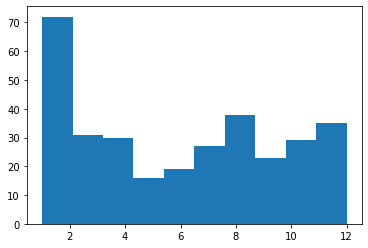

In [423]:
plt.hist(b)

In [421]:
a.value_counts()

2014    32
2001    31
2012    28
2004    28
2000    26
2011    25
2008    22
2007    22
2009    19
2002    18
2010    16
2005    16
2013    12
2003    11
2015     7
2006     7
dtype: int64

(array([26., 31., 18., 11., 28., 16.,  7., 22., 22., 19., 16., 25., 28.,
        12., 32.,  7.]),
 array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014, 2015, 2016]),
 <a list of 16 Patch objects>)

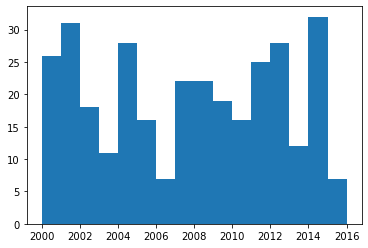

In [422]:
plt.hist(a, bins=range(2000, 2017))

In [320]:
np.datetime64(ys[0])

ValueError: Could not convert object to NumPy datetime

In [319]:
ys[0]

array([b'2011-06-01T05:00:00.000000000', b'2011-05-22T14:00:00.000000000',
       b'2012-10-14T06:00:00.000000000', b'2004-05-04T06:00:00.000000000',
       b'2004-05-10T14:00:00.000000000', b'2007-02-18T03:00:00.000000000',
       b'2011-05-26T19:00:00.000000000', b'2012-11-06T07:00:00.000000000',
       b'2004-04-19T06:00:00.000000000', b'2012-10-12T16:00:00.000000000',
       b'2011-05-25T06:00:00.000000000', b'2011-06-08T21:00:00.000000000',
       b'2005-09-08T07:00:00.000000000', b'2008-07-31T14:00:00.000000000',
       b'2010-01-01T21:00:00.000000000', b'2011-06-10T17:00:00.000000000',
       b'2008-07-10T02:00:00.000000000', b'2011-05-05T20:00:00.000000000',
       b'2014-03-19T09:00:00.000000000', b'2009-12-16T02:00:00.000000000',
       b'2004-04-08T09:00:00.000000000', b'2007-02-23T00:00:00.000000000',
       b'2012-11-05T11:00:00.000000000', b'2010-01-05T21:00:00.000000000',
       b'2000-01-28T22:00:00.000000000', b'2004-04-14T03:00:00.000000000',
       b'2008-07-11T10:00

In [306]:
ys[0][0]

b'2007-02-07T13:00:00.000000000'

In [305]:
Xs[4243][0]

array([b'2012-10-04T16:00:00.000000000', b'2012-10-04T17:00:00.000000000',
       b'2012-10-04T18:00:00.000000000'], dtype=object)

In [307]:
ys[4243][0]

b'2012-10-07T18:00:00.000000000'

In [298]:
l

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [284]:
Xs[0][0]

array([b'2007-02-04T11:00:00.000000000', b'2007-02-04T12:00:00.000000000',
       b'2007-02-04T13:00:00.000000000'], dtype=object)

In [285]:
Xs[-1][0]

array([b'2014-03-17T22:00:00.000000000', b'2014-03-17T23:00:00.000000000',
       b'2014-03-18T00:00:00.000000000'], dtype=object)

## Naive implementation... I give up

In [8]:
args = load_args('../nn_configs/TFR/001-era_std_in_zt_out_3d.yml')

In [13]:
args['train_years'] = ['2015', '2015']
args['valid_years'] = ['2015', '2015']
args['test_years'] = ['2015', '2015']
args['batch_size'] = 1

In [14]:
%%time
dg_train, dg_valid, dg_test = load_data(**args)

CPU times: user 20.2 s, sys: 24.1 s, total: 44.3 s
Wall time: 27 s


In [117]:
dg_train.mean.to_netcdf('/data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/mean.nc')
dg_train.std.to_netcdf('/data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/std.nc')

In [15]:
X, y = dg_train[0]

In [16]:
X.shape, y.shape

((1, 32, 64, 114), (1, 32, 64, 2))

In [17]:
len(dg_train)

8686

In [18]:
tfrdir = '/data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/'
os.mkdir(tfrdir)

In [123]:
a is None

False

In [19]:
steps_per_file = 500

In [22]:
def serialize_example(X, y):
    feature = {
        'X': _tensor_feature(X),
        'y': _tensor_feature(y)
    }
    feature = tf.train.Features(feature=feature)
    example_proto = tf.train.Example(features=feature)
    return example_proto.SerializeToString()

In [81]:
writer.close()

In [82]:
!rm /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/*

In [83]:
def _tensor_feature(value):
    value = tf.io.serialize_tensor(value).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [18]:
dg_train.tfr_dataset or dg_train

<RepeatDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [84]:
for i, (X, y) in tqdm(enumerate(dg_train)):
    if i % steps_per_file == 0:
        c = int(np.floor(i/steps_per_file))
        fn = f'{tfrdir}{str(c).zfill(3)}.tfrecord'
        print('Writing to file:', fn)
        writer = tf.io.TFRecordWriter(fn)
    serialized_example = serialize_example(X[0], y[0])   # Remove batch dimension
    writer.write(serialized_example)
    if i+1 % steps_per_file == 0:
        writer.close()
writer.close()


Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/000.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/001.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/002.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/003.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/004.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/005.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/006.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/007.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/008.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/009.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-era_std_in_zt_out_3d/010.tfrecord
Writing to file: /data/stephan/WeatherBench/TFR/001-er

In [85]:
tfr_files = sorted(glob(f'{tfrdir}*.tfrecord'))

In [107]:
dataset = tf.data.TFRecordDataset(tfr_files, num_parallel_reads=17)

In [108]:
features = {
    'X': tf.io.FixedLenFeature([], tf.string),
    'y': tf.io.FixedLenFeature([], tf.string)
}

In [109]:
def _parse(example_proto):
    return tf.io.parse_single_example(example_proto, features)

In [110]:
def decode(example_proto):
    dic = _parse(example_proto)
    X = tf.io.parse_tensor(dic['X'], np.float32)
    y = tf.io.parse_tensor(dic['y'], np.float32)
    return X, y

In [111]:
dataset = dataset.map(decode)

In [112]:
dataset = dataset.batch(3)

In [113]:
for a in dataset.take(1):
    pass

In [114]:
a[1][:, 0, 0, 0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.6632149, -1.977044 , -1.7434491], dtype=float32)>

In [116]:
dg_train[1][1][0, 0, 0, 0]

-2.3843098

## Load DG

In [19]:
args = load_args('../nn_configs/B/136-resnet_tfr_ref.yml')

In [20]:
dg_train, dg_valid, dg_test = load_data(**args)

In [21]:
dg_train.tfr_dataset

<BatchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [22]:
model = build_resnet(args['filters'], args['kernels'], input_shape=dg_train.shape)

In [23]:
model.compile(tf.keras.optimizers.Adam(1e-5), 'mse')

In [25]:
history = model.fit(
    dg_train.tfr_dataset,
    epochs=1000,
    validation_data=dg_valid.tfr_dataset,
#     callbacks=callbacks
)

Epoch 1/1000


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [31]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions//136-resnet_tfr_ref.nc').load()

In [32]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8686)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-04T02:00:00 ... 2015-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t        (time, lat, lon) float64 254.8 255.4 255.5 ... 264.0 266.1 269.6
    z        (time, lat, lon) float64 5.212e+04 5.13e+04 ... 4.942e+04 4.937e+04

In [33]:
np.mean(preds.t)

<xarray.DataArray 't' ()>
array(274.41960796)

In [34]:
np.mean(preds.z)

<xarray.DataArray 'z' ()>
array(54245.15793283)

## Ok, not so naive after all

In [10]:
args = load_args('../nn_configs/TFR/002-era_std_in_zt_out_max_5d.yml')

In [11]:
args['train_years'] = ['2015', '2015']
args['valid_years'] = ['2015', '2015']
args['test_years'] = ['2015', '2015']
args['batch_size'] = 1

In [12]:
%%time
dg_train, dg_valid, dg_test = load_data(**args)

DG start 09:46:37.326543
DG load 09:46:37.361284
Loading data into RAM
DG done 09:46:43.722721
DG normalize 09:46:43.722871
CPU times: user 18.3 s, sys: 18.6 s, total: 36.9 s
Wall time: 31.5 s


In [ ]:
dg_train.batch_size

In [13]:
dg_train.data

<xarray.DataArray 'z' (time: 8760, lat: 32, lon: 64, level: 38)>
array([[[[ 0.42106513, -1.09793393, -1.19501141, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.42025475, -1.09610681, -1.18282409, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.41863397, -1.09428112, -1.17063677, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.42350401, -1.09975962, -1.22649642, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.42269363, -1.09975962, -1.21837114, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.42187938, -1.09915057, -1.20719872, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.42187938, -1.05532119, -1.14524602, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.41457432, -1.04923365, -1.12087139, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.40726539, -1.04253707, -1.09649555, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.45029697, -1.06262681, -1.18485511, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.43974264, -1.06445249, -1.17774594, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.42837406, -1.06140872, -1.16454251, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.320388  , -1.15637312, -1.2661055 , ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.29927933, -1.16063497, -1.23157457, ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.2797953 , -1.15880929, -1.1939965 , ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.40076686, -1.11497845, -1.23969743, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.37153888, -1.13445915, -1.27423078, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.34312129, -1.1484599 , -1.28540199, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-1.45773335, -1.02062166, -1.18282409, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-1.50726346, -1.00114241, -1.15946436, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-1.59170198, -0.9974896 , -1.15235519, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-1.4585476 , -1.11254518, -1.24376188, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-1.43743507, -1.07906373, -1.24173087, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-1.43418966, -1.04801557, -1.21837234, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-2.15599022, -1.2702106 , -1.31180885, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-2.19739716, -1.25012087, -1.29860542, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-2.24449225, -1.23368539, -1.28133995, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-2.11377289, -1.32925883, -1.32196515, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-2.1121444 , -1.31282335, -1.32501228, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-2.12757263, -1.29273362, -1.32094903, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-2.59930305, -1.33352068, -1.25696531, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-2.60580158, -1.33108596, -1.25391818, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-2.61392089, -1.32925883, -1.24985494, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-2.59037335, -1.34569575, -1.25696531, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-2.59199412, -1.3414339 , -1.25798022, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-2.59524339, -1.33717349, -1.25899633, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.41700548, -1.09489017, -1.18891835, ...,  1.44426201,
           2

In [15]:
i=0
idxs = dg_train.idxs[i * dg_train.batch_size:(i + 1) * dg_train.batch_size]

In [16]:
idxs

array([3191])

In [17]:
nt = dg_train.nt

In [18]:
nt

120

In [19]:
min_nt=1

In [22]:
idxs+min_nt, idxs+nt

(array([3192]), array([3311]))

In [24]:
idxs.shape

(1,)

In [28]:
dg_train.data.isel(time=slice(idxs[0]+min_nt, idxs[0]+nt+1))

<xarray.DataArray 'z' (time: 120, lat: 32, lon: 64, level: 38)>
array([[[[-3.62720625, -1.68903101, -1.64391838, ...,  1.44426201,
           2.57085561, -1.67874412],
         [-3.64344487, -1.69816231, -1.65001144, ...,  1.44426201,
           2.63684811, -1.67874412],
         [-3.65886924, -1.70790266, -1.6561057 , ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [-3.57199185, -1.66346278, -1.62766782, ...,  1.44426201,
           2.40688572, -1.67874412],
         [-3.59147974, -1.67137744, -1.63376208, ...,  1.44426201,
           2.47378905, -1.67874412],
         [-3.60933913, -1.6798997 , -1.63884023, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[-3.61908694, -1.74503546, -1.73329285, ...,  1.44426201,
           2.06275586, -1.57043805],
         [-3.66211465, -1.7505154 , -1.7170435 , ...,  1.44426201,
           2.33441714, -1.57043805],
         [-3.70028005, -1.75721053, -1.70891821, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [-3.46806544, -1.70972834, -1.78407435, ...,  1.44426201,
           1.50808802, -1.57043805],
         [-3.52490062, -1.72616526, -1.78509046, ...,  1.44426201,
           1.76416741, -1.57043805],
         [-3.57443073, -1.73712225, -1.76071582, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[-3.43071816, -1.72799094, -1.69876192, ...,  1.44426201,
           2.80071523, -1.46213197],
         [-3.49323762, -1.74807923, -1.70485618, ...,  1.44426201,
           3.12389527, -1.46213197],
         [-3.54682353, -1.76147239, -1.72516878, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [-3.16602245, -1.60623879, -1.62360458, ...,  1.44426201,
           0.85969458, -1.46213197],
         [-3.26751769, -1.66954887, -1.68352626, ...,  1.44426201,
           2.03308297, -1.46213197],
         [-3.34952505, -1.70607553, -1.6967309 , ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[ 0.79536382, -0.64015215, -0.56227734, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [ 0.80267274, -0.66937319, -0.59173013, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [ 0.81647634, -0.68885243, -0.61508986, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [ 0.76532546, -0.61275969, -0.53383947, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [ 0.78237446, -0.61275969, -0.53891762, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [ 0.79130416, -0.6206729 , -0.53891762, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[ 0.76613584, -0.82095253, -0.7735274 , ..., -0.73436932,
          -0.44130638,  1.57043805],
         [ 0.77263438, -0.8191254 , -0.75219869, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [ 0.77750442, -0.82034348, -0.74305851, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [ 0.7385325 , -0.83860609, -0.83954214, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [ 0.74908683, -0.83130047, -0.82227667, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [ 0.75801653, -0.82521293, -0.79688593, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[ 0.72635354, -0.9463546 , -0.94415226, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [ 0.72797817, -0.94757268, -0.94923041, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [ 0.73041319, -0.94818028, -0.95532347, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [ 0.71985886, -0.94818028, -0.94110513, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [ 0.72229388, -0.94696364, -0.94008902, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [ 0.7247289 , -0.9463546 , -0.94110513, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[-3.64506564, -1.69998799, -1.65813672, ...,  1.44426201,
           2.

In [29]:
dg_train.tfr_out = True

In [33]:
X, y = dg_train[0]

In [34]:
y.shape

(1, 120, 32, 64, 2)

In [35]:
X.shape

(1, 32, 64, 114)

In [36]:
dg_train.shuffle = False

In [37]:
dg_train.on_epoch_end()

In [38]:
!mkdir /home/rasp/tmp/tfr_test/

In [39]:
dg_train.to_tfr('/home/rasp/tmp/tfr_test/')

6it [00:00, 52.41it/s]

Writing to file: /home/rasp/tmp/tfr_test//000.tfrecord


258it [00:03, 70.77it/s]

Writing to file: /home/rasp/tmp/tfr_test//001.tfrecord


514it [00:07, 71.07it/s]

Writing to file: /home/rasp/tmp/tfr_test//002.tfrecord


762it [00:10, 71.56it/s]

Writing to file: /home/rasp/tmp/tfr_test//003.tfrecord


1010it [00:14, 71.15it/s]

Writing to file: /home/rasp/tmp/tfr_test//004.tfrecord


1258it [00:17, 71.24it/s]

Writing to file: /home/rasp/tmp/tfr_test//005.tfrecord


1509it [00:20, 72.75it/s]

Writing to file: /home/rasp/tmp/tfr_test//006.tfrecord


1765it [00:24, 73.31it/s]

Writing to file: /home/rasp/tmp/tfr_test//007.tfrecord


2013it [00:27, 71.31it/s]

Writing to file: /home/rasp/tmp/tfr_test//008.tfrecord


2265it [00:31, 79.34it/s]

Writing to file: /home/rasp/tmp/tfr_test//009.tfrecord


2508it [00:34, 81.64it/s]

Writing to file: /home/rasp/tmp/tfr_test//010.tfrecord


2760it [00:37, 76.68it/s]

Writing to file: /home/rasp/tmp/tfr_test//011.tfrecord


3013it [00:40, 69.64it/s]

Writing to file: /home/rasp/tmp/tfr_test//012.tfrecord


3259it [00:44, 70.55it/s]

Writing to file: /home/rasp/tmp/tfr_test//013.tfrecord


3514it [00:48, 69.33it/s]

Writing to file: /home/rasp/tmp/tfr_test//014.tfrecord


3762it [00:51, 70.41it/s]

Writing to file: /home/rasp/tmp/tfr_test//015.tfrecord


4010it [00:55, 71.36it/s]

Writing to file: /home/rasp/tmp/tfr_test//016.tfrecord


4258it [00:58, 69.82it/s]

Writing to file: /home/rasp/tmp/tfr_test//017.tfrecord


4513it [01:02, 71.88it/s]

Writing to file: /home/rasp/tmp/tfr_test//018.tfrecord


4764it [01:05, 80.79it/s]

Writing to file: /home/rasp/tmp/tfr_test//019.tfrecord


5016it [01:08, 81.72it/s]

Writing to file: /home/rasp/tmp/tfr_test//020.tfrecord


5259it [01:11, 81.00it/s]

Writing to file: /home/rasp/tmp/tfr_test//021.tfrecord


5507it [01:14, 80.45it/s]

Writing to file: /home/rasp/tmp/tfr_test//022.tfrecord


5764it [01:17, 71.38it/s]

Writing to file: /home/rasp/tmp/tfr_test//023.tfrecord


6012it [01:21, 71.06it/s]

Writing to file: /home/rasp/tmp/tfr_test//024.tfrecord


6265it [01:24, 82.07it/s]

Writing to file: /home/rasp/tmp/tfr_test//025.tfrecord


6509it [01:27, 70.21it/s]

Writing to file: /home/rasp/tmp/tfr_test//026.tfrecord


6763it [01:31, 70.07it/s]

Writing to file: /home/rasp/tmp/tfr_test//027.tfrecord


7012it [01:34, 69.77it/s]

Writing to file: /home/rasp/tmp/tfr_test//028.tfrecord


7261it [01:38, 70.54it/s]

Writing to file: /home/rasp/tmp/tfr_test//029.tfrecord


7509it [01:42, 69.69it/s]

Writing to file: /home/rasp/tmp/tfr_test//030.tfrecord


7764it [01:45, 69.57it/s]

Writing to file: /home/rasp/tmp/tfr_test//031.tfrecord


8012it [01:49, 80.81it/s]

Writing to file: /home/rasp/tmp/tfr_test//032.tfrecord


8264it [01:52, 81.27it/s]

Writing to file: /home/rasp/tmp/tfr_test//033.tfrecord


8516it [01:55, 80.85it/s]

Writing to file: /home/rasp/tmp/tfr_test//034.tfrecord


8638it [01:56, 73.98it/s]


In [40]:
dg_train.mean.to_netcdf('/home/rasp/tmp/tfr_test//mean.nc')
dg_train.std.to_netcdf('/home/rasp/tmp/tfr_test/std.nc')

In [58]:
args_tfr = load_args('../nn_configs/B/136.2-resnet_tfr_ref.yml')

In [59]:
args_tfr['train_years'] = ['2015', '2015']
args_tfr['valid_years'] = ['2015', '2015']
args_tfr['test_years'] = ['2015', '2015']
args_tfr['batch_size'] = 1
args_tfr['tfr_num_parallel_calls'] = 1

In [60]:
dg_train_tfr, dg_valid_tfr, dg_test_tfr = load_data(**args_tfr)

DG start 10:04:32.594762
DG load 10:04:32.626233
DG done 10:04:32.626630
DG normalize 10:04:32.626873


In [61]:
dg_train_tfr.shuffle = False

In [62]:
dg_train_tfr._setup_tfrecord_ds()

In [70]:
X_tfr, y_tfr = dg_train_tfr[0]

In [64]:
X_tfr.shape, y_tfr.shape

((1, 32, 64, 114), (1, 32, 64, 2))

In [121]:
dg_train.tfr_out=False
dg_train.lead_time=72
dg_train.on_epoch_end()

In [122]:
X, y = dg_train[0]

In [123]:
X.shape, y.shape

((1, 32, 64, 114), (1, 32, 64, 2))

In [124]:
X_tfr[0, 0, 0, 0], X[0, 0, 0, 0]

(0.41700548, 0.42106512)

In [125]:
y_tfr[0, 0, 0, 0], y[0, 0, 0, 0]

(-1.0365739, -1.041652)

In [89]:
tf.random.uniform((), 0, 10, dtype=tf.int32)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [168]:
dg_train_tfr.cont_time = True
dg_train_tfr.min_nt = 1
dg_train_tfr._setup_tfrecord_ds()

In [169]:
X, y = dg_train_tfr[0]

In [170]:
X.shape

(1, 32, 64, 115)

In [172]:
X[..., -1]

array([[[0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
        [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
        [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
        ...,
        [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
        [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72],
        [0.72, 0.72, 0.72, ..., 0.72, 0.72, 0.72]]], dtype=float32)

In [159]:
for X, y, time in dg_train_tfr.tfr_dataset.take(1):
    pass

In [164]:
ftime = (time / 100) * np.ones((1, len(dg_train_tfr.data.lat), len(dg_train_tfr.data.lon), 1))

In [161]:
X.shape, ftime.shape

(TensorShape([1, 32, 64, 114]), TensorShape([1, 32, 64, 1]))

In [163]:
tf.concat([X, ftime], -1)

<tf.Tensor: shape=(1, 32, 64, 115), dtype=float32, numpy=
array([[[[ 0.42106512, -1.0979339 , -1.1950114 , ...,  2.5708556 ,
          -1.6787441 ,  0.72      ],
         [ 0.42025474, -1.0961068 , -1.1828241 , ...,  2.6368482 ,
          -1.6787441 ,  0.72      ],
         [ 0.41863397, -1.0942811 , -1.1706368 , ...,  2.7012208 ,
          -1.6787441 ,  0.72      ],
         ...,
         [ 0.42350402, -1.0997596 , -1.2264965 , ...,  2.4068856 ,
          -1.6787441 ,  0.72      ],
         [ 0.42269364, -1.0997596 , -1.2183712 , ...,  2.473789  ,
          -1.6787441 ,  0.72      ],
         [ 0.42187938, -1.0991505 , -1.2071987 , ...,  2.522474  ,
          -1.6787441 ,  0.72      ]],

        [[ 0.42187938, -1.0553212 , -1.145246  , ...,  2.0627558 ,
          -1.570438  ,  0.72      ],
         [ 0.41457433, -1.0492337 , -1.1208714 , ...,  2.334417  ,
          -1.570438  ,  0.72      ],
         [ 0.4072654 , -1.0425371 , -1.0964955 , ...,  2.4794586 ,
          -1.570438  ,  0.7

In [120]:
X[0,0,0,0], y[0,0,0,0]

(0.42106512, -1.041652)

In [194]:
ds = xr.open_mfdataset('/data/stephan/WeatherBench/5.625deg/temperature/temperature_197*', combine='by_coords')
ds2 = xr.open_mfdataset('/data/stephan/WeatherBench/5.625deg/specific_humidity//specific_humidity_197*', combine='by_coords')

In [195]:
ds = xr.merge([ds, ds2])

In [196]:
ds

<xarray.Dataset>
Dimensions:  (lat: 32, level: 13, lon: 64, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    q        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>

In [197]:
ds['t'] = np.log(ds['t'])

In [198]:
ds.mean().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float32 5.486719
    q        float32 0.0017704098

## Evaluate reference runs

In [199]:
args = load_args('../nn_configs/B/140-resnet_tfr_ref2.yml')

In [200]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 11:01:53.776715
DG normalize 11:01:53.816211
DG load 11:01:53.827453
DG done 11:01:53.827517


In [202]:
dg_test.valid_time

<xarray.DataArray 'time' (time: 17446)>
array(['2017-01-04T02:00:00.000000000', '2017-01-04T03:00:00.000000000',
       '2017-01-04T04:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T02:00:00 ... 2018-12-31T23:00:00
Attributes:
    long_name:  time

In [206]:
model = load_model(args)

In [207]:
preds = create_predictions(model, dg_test)

In [209]:
valdir = args['datadir']
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid], compat='override')

In [211]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    t        float64 1.817
    z        float64 311.5

## Evaluate continuous run

In [232]:
args = load_args('../nn_configs/B/141-resnet_cont_tfr_ref2.yml')

In [233]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 11:19:24.410096
DG normalize 11:19:24.443408
DG load 11:19:24.451271
DG done 11:19:24.451313


In [214]:
model = load_model(args)

In [234]:
preds = create_cont_predictions(model, dg_test, lead_time=[72, 120])


100%|██████████| 2/2 [00:53<00:00, 26.56s/it]


In [236]:
evaluate_iterative_forecast(preds, valid, compute_weighted_rmse).compute()

<xarray.Dataset>
Dimensions:    (lead_time: 2)
Coordinates:
    level      int32 500
  * lead_time  (lead_time) int64 72 120
Data variables:
    t          (lead_time) float64 1.838 2.557
    z          (lead_time) float64 319.7 540.3